In [1]:
# analysis.ipynb

"""
Analysis Script
Author: Imran Feisal
Date: 31/10/2024
Description:
This Jupyter notebook performs clustering and visualization on the latent features
and TabNet predictions, uses advanced clustering methods to determine the optimal
number of clusters, selects the best clustering algorithm based on validation metrics,
and provides in-depth analysis.

Inspiration: 
- Xu, Y., Goodacre, S., & Hall, M. (2018). Developing a Dynamic Health Index Using Machine Learning to Predict Patient Deterioration. IEEE Journal of Biomedical and Health Informatics, 22(3), 919-925.
- McInnes, L., Healy, J., & Melville, J. (2018). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. arXiv preprint arXiv:1802.03426.
"""


'\nAnalysis Script\nAuthor: Imran Feisal\nDate: 31/10/2024\nDescription:\nThis Jupyter notebook performs clustering and visualization on the latent features\nand TabNet predictions, uses advanced clustering methods to determine the optimal\nnumber of clusters, selects the best clustering algorithm based on validation metrics,\nand provides in-depth analysis.\n\nInspiration: \n- Xu, Y., Goodacre, S., & Hall, M. (2018). Developing a Dynamic Health Index Using Machine Learning to Predict Patient Deterioration. IEEE Journal of Biomedical and Health Informatics, 22(3), 919-925.\n- McInnes, L., Healy, J., & Melville, J. (2018). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. arXiv preprint arXiv:1802.03426.\n'


# Import necessary libraries

In [19]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import shapiro, levene, f_oneway, kruskal
import umap.umap_ as umap
import warnings


warnings.filterwarnings('ignore')



# Set random seed for reproducibility

In [3]:
np.random.seed(42)

In [4]:
# Load data
latent_features = pd.read_csv('latent_features_vae.csv')
tabnet_predictions = pd.read_csv('tabnet_predictions.csv')
data = latent_features.merge(tabnet_predictions, on='Id', how='inner')
X = data.drop(columns=['Id', 'Predicted_Health_Index'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



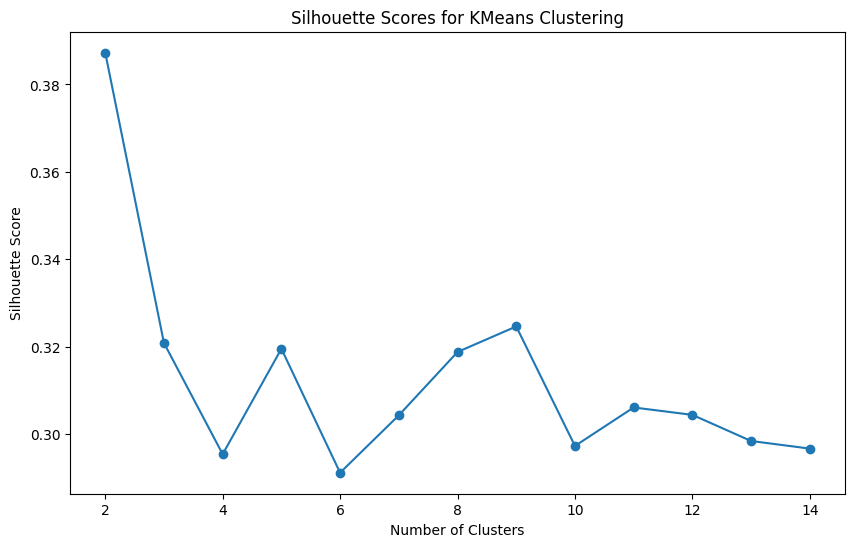

In [5]:
# ------------------------------
# KMeans Clustering
# ------------------------------

silhouette_scores_kmeans = []
cluster_range = range(2, 15)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    silhouette_scores_kmeans.append(silhouette)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores_kmeans, marker='o')
plt.title('Silhouette Scores for KMeans Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [6]:
# Select the second-best silhouette score
sorted_indices = np.argsort(silhouette_scores_kmeans)[::-1]
second_best_index = sorted_indices[1]  # Second-best score
optimal_clusters_kmeans = cluster_range[second_best_index]
print(f"Second-best number of clusters for KMeans: {optimal_clusters_kmeans}")

# Perform KMeans clustering with the second-best number of clusters
kmeans = KMeans(n_clusters=optimal_clusters_kmeans, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)


Second-best number of clusters for KMeans: 9


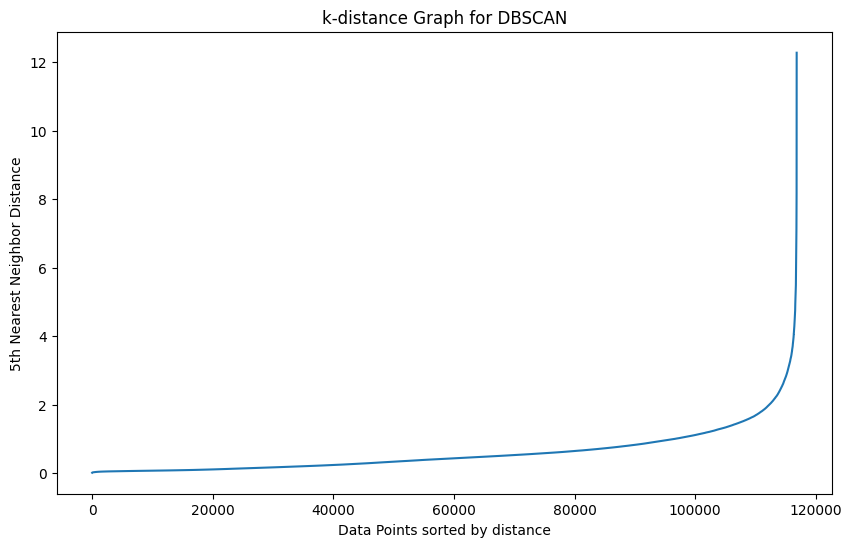

In [9]:
# ------------------------------
# DBSCAN Clustering
# ------------------------------

nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('k-distance Graph for DBSCAN')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.show()


In [10]:
# From the plot, choose an epsilon value where the distance starts to increase sharply
epsilon = 1.5  # Adjust based on the k-distance graph
dbscan = DBSCAN(eps=epsilon, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)


In [11]:
# ------------------------------
# Cluster Validation Metrics
# ------------------------------
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
ch_score_kmeans = calinski_harabasz_score(X_scaled, kmeans_labels)
db_score_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)

validation_scores = pd.DataFrame({
    'Clustering_Method': ['KMeans', 'DBSCAN'],
    'Silhouette_Score': [silhouette_kmeans, np.nan],  # DBSCAN might not have valid silhouette
    'Calinski_Harabasz_Score': [ch_score_kmeans, np.nan],
    'Davies_Bouldin_Score': [db_score_kmeans, np.nan]
})

display(validation_scores)



,Clustering_Method,Silhouette_Score,Calinski_Harabasz_Score,Davies_Bouldin_Score
0,KMeans,0.324637,20636.928197,1.259277
1,DBSCAN,NaN,NaN,NaN


In [12]:
# Assign Clusters and Map Severity Index
data['Cluster'] = kmeans_labels
data = data[data['Cluster'] != -1]
cluster_severity = data.groupby('Cluster')['Predicted_Health_Index'].mean().sort_values().reset_index()
cluster_severity['Severity_Index'] = range(1, len(cluster_severity) + 1)
severity_mapping = cluster_severity.set_index('Cluster')['Severity_Index'].to_dict()
data['Severity_Index'] = data['Cluster'].map(severity_mapping)


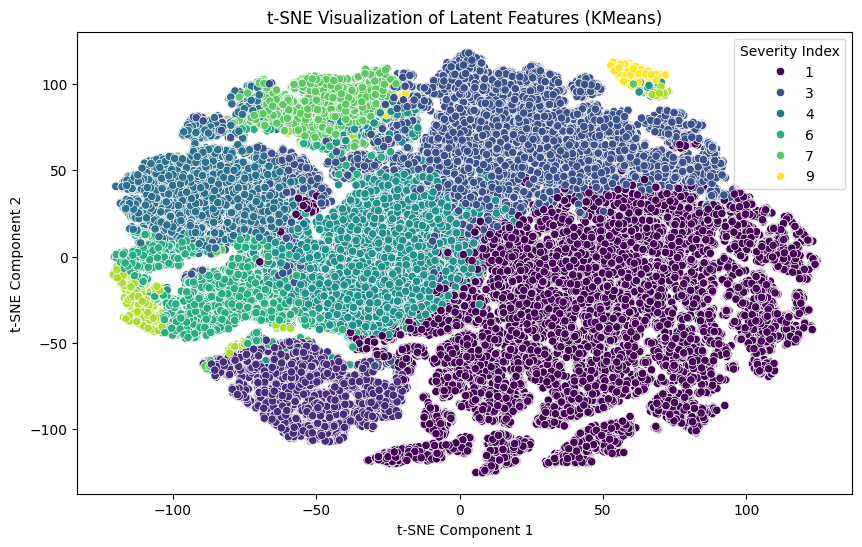

In [13]:
# ------------------------------
# t-SNE Visualization
# ------------------------------

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=data['Severity_Index'], palette='viridis')
plt.title('t-SNE Visualization of Latent Features (KMeans)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Severity Index')
plt.show()


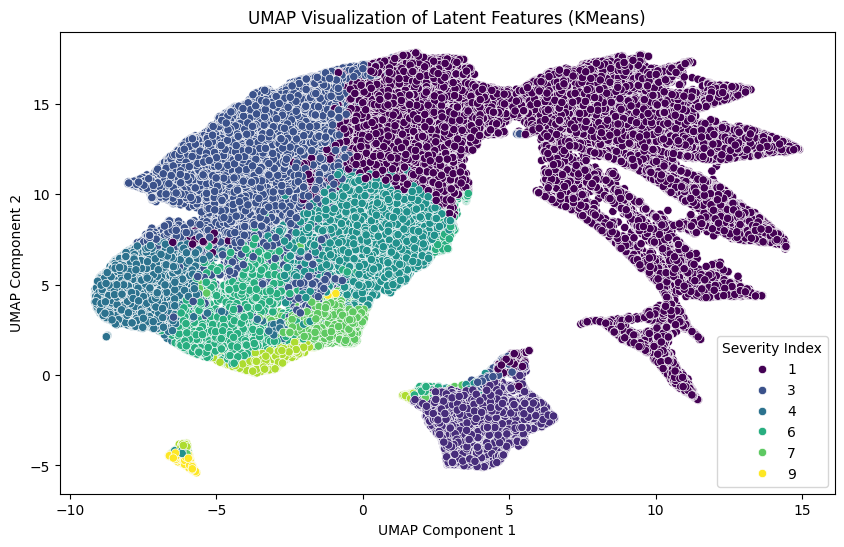

In [14]:
# ------------------------------
# UMAP Visualization
# ------------------------------
reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = reducer.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], hue=data['Severity_Index'], palette='viridis')
plt.title('UMAP Visualization of Latent Features (KMeans)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Severity Index')
plt.show()


In [20]:
# ------------------------------
# Statistical Analysis
# ------------------------------
normality_pvalues = []
for cluster in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster]['Predicted_Health_Index']
    stat, p = shapiro(cluster_data)
    normality_pvalues.append(p)

# If any p-value is less than 0.05, normality is violated
if any(p < 0.05 for p in normality_pvalues):
    print("Normality assumption violated in at least one cluster. Using Kruskal-Wallis test.")
    # Perform Kruskal-Wallis test
    kruskal_result = kruskal(*(data[data['Cluster'] == cluster]['Predicted_Health_Index'] for cluster in data['Cluster'].unique()))
    print(f"Kruskal-Wallis H-statistic: {kruskal_result.statistic:.4f}, p-value: {kruskal_result.pvalue:.4e}")
else:
    # Check homogeneity of variances
    stat, p = levene(*(data[data['Cluster'] == cluster]['Predicted_Health_Index'] for cluster in data['Cluster'].unique()))
    if p < 0.05:
        print("Homogeneity of variances assumption violated. Using Kruskal-Wallis test.")
        # Perform Kruskal-Wallis test
        kruskal_result = kruskal(*(data[data['Cluster'] == cluster]['Predicted_Health_Index'] for cluster in data['Cluster'].unique()))
        print(f"Kruskal-Wallis H-statistic: {kruskal_result.statistic:.4f}, p-value: {kruskal_result.pvalue:.4e}")
    else:
        # Perform ANOVA
        anova_result = f_oneway(*(data[data['Cluster'] == cluster]['Predicted_Health_Index'] for cluster in data['Cluster'].unique()))
        print(f"ANOVA F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}")


Normality assumption violated in at least one cluster. Using Kruskal-Wallis test.
Kruskal-Wallis H-statistic: 66927.7061, p-value: 0.0000e+00


In [21]:
# ------------------------------
# Save Analysis Results
# ------------------------------


# Save Results
data.to_csv('analysis_results.csv', index=False)
print("Analysis results saved.")



Analysis results saved.


In [1]:
# analysis.py
# Modified Analysis Script
# Author: Imran Feisal
# Date: 31/10/2024
# Description:
# Updated to remove Agglomerative Clustering and use the second-best silhouette score for KMeans.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import shapiro, levene, f_oneway, kruskal
from scikit_posthocs import posthoc_dunn
import umap.umap_ as umap
import warnings

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load data
latent_features = pd.read_csv('latent_features_vae.csv')
tabnet_predictions = pd.read_csv('tabnet_predictions.csv')
data = latent_features.merge(tabnet_predictions, on='Id', how='inner')
X = data.drop(columns=['Id', 'Predicted_Health_Index'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans Clustering
silhouette_scores_kmeans = []
cluster_range = range(2, 15)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    silhouette_scores_kmeans.append(silhouette)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores_kmeans, marker='o')
plt.title('Silhouette Scores for KMeans Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Select the second-best silhouette score
sorted_indices = np.argsort(silhouette_scores_kmeans)[::-1]
second_best_index = sorted_indices[1]  # Second-best score
optimal_clusters_kmeans = cluster_range[second_best_index]
print(f"Second-best number of clusters for KMeans: {optimal_clusters_kmeans}")

# Perform KMeans clustering with the second-best number of clusters
kmeans = KMeans(n_clusters=optimal_clusters_kmeans, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# DBSCAN Clustering
nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)
distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('k-distance Graph for DBSCAN')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.show()

epsilon = 1.5  # Adjust based on the k-distance graph
dbscan = DBSCAN(eps=epsilon, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Validation Metrics
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
ch_score_kmeans = calinski_harabasz_score(X_scaled, kmeans_labels)
db_score_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)

validation_scores = pd.DataFrame({
    'Clustering_Method': ['KMeans', 'DBSCAN'],
    'Silhouette_Score': [silhouette_kmeans, np.nan],  # DBSCAN might not have valid silhouette
    'Calinski_Harabasz_Score': [ch_score_kmeans, np.nan],
    'Davies_Bouldin_Score': [db_score_kmeans, np.nan]
})

display(validation_scores)

# Assign Clusters and Map Severity Index
data['Cluster'] = kmeans_labels
data = data[data['Cluster'] != -1]
cluster_severity = data.groupby('Cluster')['Predicted_Health_Index'].mean().sort_values().reset_index()
cluster_severity['Severity_Index'] = range(1, len(cluster_severity) + 1)
severity_mapping = cluster_severity.set_index('Cluster')['Severity_Index'].to_dict()
data['Severity_Index'] = data['Cluster'].map(severity_mapping)

# Statistical Analysis
# Check assumptions for ANOVA
# 1. Normality within each group
normality_pvalues = []
for cluster in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster]['Predicted_Health_Index']
    stat, p = shapiro(cluster_data)
    normality_pvalues.append(p)

# If any p-value is less than 0.05, normality is violated
if any(p < 0.05 for p in normality_pvalues):
    print("Normality assumption violated in at least one cluster. Using Kruskal-Wallis test.")
    # Perform Kruskal-Wallis test
    kruskal_result = kruskal(*(data[data['Cluster'] == cluster]['Predicted_Health_Index'] for cluster in data['Cluster'].unique()))
    print(f"Kruskal-Wallis H-statistic: {kruskal_result.statistic:.4f}, p-value: {kruskal_result.pvalue:.4e}")

    # Post hoc analysis using Dunn's test
    posthoc_results = posthoc_dunn(data, val_col='Predicted_Health_Index', group_col='Cluster', p_adjust='bonferroni')
    print("Post hoc Dunn's test results:")
    print(posthoc_results)
else:
    # Check homogeneity of variances
    stat, p = levene(*(data[data['Cluster'] == cluster]['Predicted_Health_Index'] for cluster in data['Cluster'].unique()))
    if p < 0.05:
        print("Homogeneity of variances assumption violated. Using Kruskal-Wallis test.")
        # Perform Kruskal-Wallis test
        kruskal_result = kruskal(*(data[data['Cluster'] == cluster]['Predicted_Health_Index'] for cluster in data['Cluster'].unique()))
        print(f"Kruskal-Wallis H-statistic: {kruskal_result.statistic:.4f}, p-value: {kruskal_result.pvalue:.4e}")

        # Post hoc analysis using Dunn's test
        posthoc_results = posthoc_dunn(data, val_col='Predicted_Health_Index', group_col='Cluster', p_adjust='bonferroni')
        print("Post hoc Dunn's test results:")
        print(posthoc_results)
    else:
        # Perform ANOVA
        anova_result = f_oneway(*(data[data['Cluster'] == cluster]['Predicted_Health_Index'] for cluster in data['Cluster'].unique()))
        print(f"ANOVA F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}")

# Visualization of Cluster Differences
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='Predicted_Health_Index', data=data, palette='viridis')
plt.title('Boxplot of Predicted Health Index by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Predicted Health Index')
plt.show()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=data['Severity_Index'], palette='viridis')
plt.title('t-SNE Visualization of Latent Features (KMeans)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Severity Index')
plt.show()

# UMAP Visualization
reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = reducer.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], hue=data['Severity_Index'], palette='viridis')
plt.title('UMAP Visualization of Latent Features (KMeans)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Severity Index')
plt.show()

# Save Results
data.to_csv('analysis_results.csv', index=False)
print("Analysis results saved.")


ModuleNotFoundError: No module named 'scikit_posthocs'

In [3]:
import os
import pandas as pd

# Directory containing the CSV files
directory = 'E:\synthea-master\output\csv\conditions.csv'

csv_file = pd.read_csv(directory)

csv_file.head()

unique_codes = csv_file[['CODE', 'DESCRIPTION']].drop_duplicates()
unique_codes_list = unique_codes.values.tolist()
unique_codes_list

[[314529007, 'Medication review due (situation)'],
 [195662009, 'Acute viral pharyngitis (disorder)'],
 [10509002, 'Acute bronchitis (disorder)'],
 [109570002, 'Primary dental caries (disorder)'],
 [66383009, 'Gingivitis (disorder)'],
 [18718003, 'Gingival disease (disorder)'],
 [125605004, 'Fracture of bone (disorder)'],
 [263102004, 'Fracture subluxation of wrist (disorder)'],
 [160968000, 'Risk activity involvement (finding)'],
 [43878008, 'Streptococcal sore throat (disorder)'],
 [427898007, 'Infection of tooth (disorder)'],
 [444814009, 'Viral sinusitis (disorder)'],
 [60234000, 'Aortic valve regurgitation (disorder)'],
 [40055000, 'Chronic sinusitis (disorder)'],
 [110030002, 'Concussion injury of brain (disorder)'],
 [62564004, 'Concussion with loss of consciousness (disorder)'],
 [840544004,
  'Suspected disease caused by Severe acute respiratory coronavirus 2 (situation)'],
 [248595008, 'Sputum finding (finding)'],
 [43724002, 'Chill (finding)'],
 [386661006, 'Fever (finding)'